In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import torch
import matplotlib.pyplot as plt
from PIL import Image
import tarfile
import os
import zipfile
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import pandas


## Extract Files

In [0]:
root_dir = "/content/drive/My Drive/deep_learning" #change this to the present working directory
flower_dir = "flowersstuff" #Folder containing the flower data
extract_flowers = os.path.join(flower_dir,"flowers_data/jpg") #Folder containing JPG images
train_file = os.path.join(flower_dir,"trainfile.txt") #Folder containing training data, used the one in main directory
test_file = os.path.join(flower_dir,"testfile.txt") #Folder containing test data, used the one in main directory
val_file = os.path.join(flower_dir,"valfile.txt") #Folder containing validation data, used the one in main directory

def untar():
    if not os.path.isdir("flowersstuff"):
        #Data was originally zipped. Unzipping zipped data
        with zipfile.ZipFile(os.path.join(root_dir,"flowersstuff.zip"), 'r') as zip_ref:
            zip_ref.extractall(".")
    if not os.path.isdir(os.path.join(flower_dir,"flowers_data")):
        #Unzipping zipped 102flowers
        with zipfile.ZipFile(os.path.join(flower_dir,"102flowers.zip"), 'r') as zip_ref:
            zip_ref.extractall("flowersstuff")

if __name__=="__main__":
    untar()

In [0]:
! cd flowersstuff 

102flowers.zip	 imagelabels.npy       trainfile.txt
flowers_data	 readflowerslabels.py  valfile.txt
imagelabels.mat  testfile.txt	       valtestfile.txt


Without pre training...
Epoch 0/10
----------


current best 0.18382352941176472  at epoch  0
Epoch 1/10
----------


current best 0.29820261437908496  at epoch  1
Epoch 2/10
----------


current best 0.34477124183006536  at epoch  2
Epoch 3/10
----------


current best 0.3194444444444444  at epoch  2
Epoch 4/10
----------


current best 0.41911764705882354  at epoch  4
Epoch 5/10
----------


current best 0.49754901960784315  at epoch  5
Epoch 6/10
----------


current best 0.505718954248366  at epoch  6
Epoch 7/10
----------


current best 0.571078431372549  at epoch  7
Epoch 8/10
----------


current best 0.5727124183006536  at epoch  8
Epoch 9/10
----------


current best 0.613562091503268  at epoch  9
Epoch 10/10
----------


current best 0.6200980392156863  at epoch  10
validation accuracy 0.6200980392156863
Test Accuracy: 0.5751173708920188


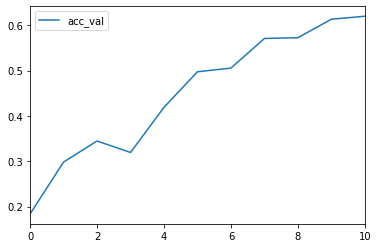

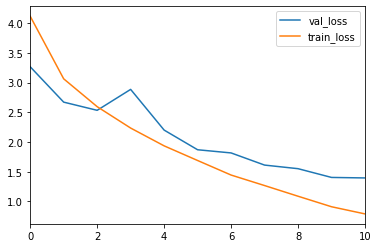

With pre training
Epoch 0/10
----------


current best 0.7116013071895425  at epoch  0
Epoch 1/10
----------


current best 0.8455882352941176  at epoch  1
Epoch 2/10
----------


current best 0.9068627450980392  at epoch  2
Epoch 3/10
----------


current best 0.9428104575163399  at epoch  3
Epoch 4/10
----------


current best 0.9550653594771242  at epoch  4
Epoch 5/10
----------


current best 0.9575163398692811  at epoch  5
Epoch 6/10
----------


current best 0.9575163398692811  at epoch  5
Epoch 7/10
----------


current best 0.9550653594771242  at epoch  5
Epoch 8/10
----------


current best 0.9575163398692811  at epoch  5
Epoch 9/10
----------


current best 0.954248366013072  at epoch  5
Epoch 10/10
----------


current best 0.9583333333333334  at epoch  10
validation accuracy 0.9583333333333334
Test Accuracy: 0.945226917057903


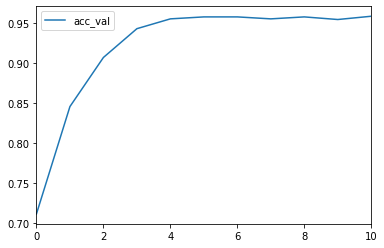

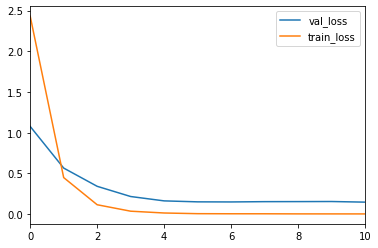

In [17]:
class resnet_dataset(Dataset):
    def __init__(self, image_folder,image_file,transform=None):
        self.image_folder = image_folder
        # self.images = [file for file in os.listdir(image_folder)]
        self.name_label = self.get_mapping(image_file)
        self.images = list(self.name_label.keys())
        self.transform = transform
    
    def get_mapping(self, image_file):
        names_labels = {}
        for line in open(image_file,"r").read().split("\n"):
            nl= line.split(" ")
            if len(nl) > 1:
                names_labels.update({nl[0]:nl[1]})
        return names_labels
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        sample = Image.open(os.path.join(self.image_folder,self.images[idx]))
        labels = self.name_label.get(self.images[idx])
        if self.transform is not None:
            sample = self.transform(sample)
        
        return (sample,int(labels))

class rescale(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        image = sample
        w = image.size[0]
        h = image.size[1]
        if h > w:
            new_h, new_w = self.size * h / w, self.size
        else:
            new_h, new_w = self.size, self.size * w / h
        new_h, new_w = int(new_h), int(new_w)
        rsz = transforms.Resize((new_h,new_w))

        return rsz(image)

def train(model,device,dataloader,optimizer,criterion):
    losses = []
    for _,data in enumerate(tqdm(dataloader,0)):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return sum(losses)/len(losses)

def eval(model, device, dataloader, criterion):
    total = 0
    correct = 0
    losses = []
    with torch.no_grad():
        for _,data in enumerate(dataloader):
            images, labels = data[0].to(device), data[1].to(device)
            output = model(images)
            loss = criterion(output, labels)
            _, pred = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (labels==pred).sum().item()
            losses.append(loss)
    return correct/total, sum(losses)/len(losses)

def train_epochs(model, device, train_dataloader, val_dataloader, optimizer, criterion, no_epochs):
    best_measure = 0
    best_epoch =-1
    metrics = {}
    for epochs in range(no_epochs):
        print('Epoch {}/{}'.format(epochs, no_epochs - 1))
        print('-' * 10)
        model.train(True)
        tr_loss = train(model, device, train_dataloader, optimizer, criterion)
        model.train(False)
        measure, b_loss_val = eval(model, device, val_dataloader, criterion)
        interm_metrics = {"acc_val":measure, "val_loss":b_loss_val.item(),"train_loss":tr_loss.item()}
        metrics[epochs] = interm_metrics
        if measure > best_measure:
            bestweights= model.state_dict()
            best_measure = measure
            best_epoch = epochs
        print('current best', measure, ' at epoch ', best_epoch)
        # break
        # print(metrics)
    return bestweights, best_measure, metrics


def run(pretrained):
    trans = transforms.Compose([rescale(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
                        
    res_train = resnet_dataset(extract_flowers,train_file,transform=trans)
    res_test = resnet_dataset(extract_flowers,test_file,transform=trans)
    res_val = resnet_dataset(extract_flowers,val_file,transform=trans)

    train_dataloader = DataLoader(res_train, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(res_val, batch_size=32, shuffle=False)
    test_dataloader = DataLoader(res_test, batch_size=32, shuffle=False)
    
    device = torch.device("cuda")
    resnet = models.resnet18(pretrained=pretrained)
    resnet.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)

    best_weights, best_measure, metrics = train_epochs(resnet, device, train_dataloader, val_dataloader, optimizer, criterion, 11)
    print('validation accuracy',best_measure)
    resnet.load_state_dict(best_weights)

    test_acc, _ = eval(resnet, device, test_dataloader, criterion)
    print("="*10)
    print("Test Accuracy:", test_acc)
    listed = list(metrics.values())
    df = pandas.DataFrame(data = listed)
    df.plot(y=['acc_val'])
    df.plot(y=['val_loss','train_loss'])
    plt.show()
    

if __name__=="__main__":
    print("Without pre training...")
    run(pretrained=False)
    print("With pre training")
    run(pretrained=True)

Epoch 0/10
----------


current best 0.8325163398692811  at epoch  0
Epoch 1/10
----------


current best 0.8970588235294118  at epoch  1
Epoch 2/10
----------


current best 0.9150326797385621  at epoch  2
Epoch 3/10
----------


current best 0.9281045751633987  at epoch  3
Epoch 4/10
----------


current best 0.9272875816993464  at epoch  3
Epoch 5/10
----------


current best 0.9330065359477124  at epoch  5
Epoch 6/10
----------


current best 0.9281045751633987  at epoch  5
Epoch 7/10
----------


current best 0.9330065359477124  at epoch  5
Epoch 8/10
----------


current best 0.9370915032679739  at epoch  8
Epoch 9/10
----------


current best 0.9370915032679739  at epoch  8
Epoch 10/10
----------


current best 0.9379084967320261  at epoch  10
validation accuracy 0.9379084967320261
Test Accuracy: 0.9287949921752738


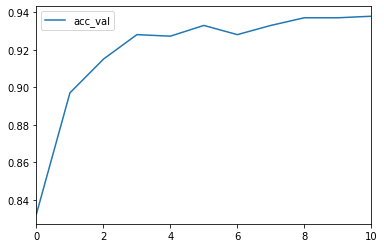

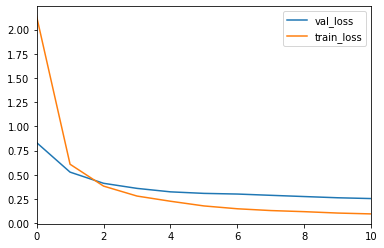

In [23]:
def run_two_layer():
    trans = transforms.Compose([rescale(224),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
                        
    res_train = resnet_dataset(extract_flowers,train_file,transform=trans)
    res_test = resnet_dataset(extract_flowers,test_file,transform=trans)
    res_val = resnet_dataset(extract_flowers,val_file,transform=trans)

    train_dataloader = DataLoader(res_train, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(res_val, batch_size=32, shuffle=False)
    test_dataloader = DataLoader(res_test, batch_size=32, shuffle=False)
    
    device = torch.device("cuda")

    model = models.resnet18(pretrained=True)
    #freeze all layers

    for param in model.parameters():
        param.requires_grad = False

    model.layer4.requires_grad = True
    model.fc = nn.Linear(512,102)

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    best_weights, best_measure, metrics = train_epochs(model, device, train_dataloader, val_dataloader, optimizer, criterion, 11)
    print('validation accuracy',best_measure)
    model.load_state_dict(best_weights)

    test_acc, _ = eval(model, device, test_dataloader, criterion)
    print("="*10)
    print("Test Accuracy:", test_acc)
    listed = list(metrics.values())
    df = pandas.DataFrame(data = listed)
    df.plot(y=['acc_val'])
    df.plot(y=['val_loss','train_loss'])
    plt.show()


if __name__ == "__main__":
    run_two_layer()

## Results

Test accuracy for mode A: 0.5751173708920188

Test accuracy for mode B: 0.945226917057903

Test accuracy for mode C: 0.9287949921752738

In this case, the partial pre-trained model was not a good substitute for a fully trained model

